In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, isnan, isnull
from pyspark.sql.types import IntegerType, StringType, FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.appName(
            "SentimentAnalysisBaseline"
        ).config(
            "spark.executor.memory", "16g"
        ).config(
            "spark.driver.memory", "32g"
        ).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/27 02:16:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv("../ggg_sg.csv", header=True, inferSchema=True, multiLine=True, escape='"')

In [5]:
df.show()

+-------------------+--------------------+--------------------+--------------------+--------+-----------------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|           DateTime|                 URL|               Title|        SharingImage|LangCode|          DocTone|DomainCountryCode| Location|   Lat|  Lon|CountryCode|Adm1Code|Adm2Code|GeoType|      ContextualText|           the_geom|
+-------------------+--------------------+--------------------+--------------------+--------+-----------------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|2022-08-18 19:15:00|https://www.goal....|How to watch Manc...|https://assets.go...|     eng|0.764331210191083|               SP|Singapore|1.3667|103.8|         SN|      SN|    null|      1|nunez added to kl...|POINT(103.8 1.3667)|
|2021-03-09 01:30:00|https://www.labma...|Vetter Announces ...|https://w

In [6]:
df = df.filter(df.ContextualText.isNotNull())
df = df.filter(df.DocTone.isNotNull())

In [7]:
df = df.withColumn("DocTone", df["DocTone"].cast(FloatType()))

In [8]:
df.show(10)

+-------------------+--------------------+--------------------+--------------------+--------+-----------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|           DateTime|                 URL|               Title|        SharingImage|LangCode|    DocTone|DomainCountryCode| Location|   Lat|  Lon|CountryCode|Adm1Code|Adm2Code|GeoType|      ContextualText|           the_geom|
+-------------------+--------------------+--------------------+--------------------+--------+-----------+-----------------+---------+------+-----+-----------+--------+--------+-------+--------------------+-------------------+
|2022-08-18 19:15:00|https://www.goal....|How to watch Manc...|https://assets.go...|     eng|  0.7643312|               SP|Singapore|1.3667|103.8|         SN|      SN|    null|      1|nunez added to kl...|POINT(103.8 1.3667)|
|2021-03-09 01:30:00|https://www.labma...|Vetter Announces ...|https://www.labma...|     eng|   

# Exploratory Data Analysis (DocTone)

In [9]:
from pyspark.sql.functions import col, min, max, avg, stddev, percentile_approx

stats = df.select(
    min(col("DocTone")).alias("min_DocTone"),
    max(col("DocTone")).alias("max_DocTone"),
    avg(col("DocTone")).alias("avg_DocTone"),
    stddev(col("DocTone")).alias("stddev_DocTone")
).collect()[0]

print("DocTone Statistics:")
print(f"Min: {stats['min_DocTone']}")
print(f"Max: {stats['max_DocTone']}")
print(f"Average: {stats['avg_DocTone']}")
print(f"Standard Deviation: {stats['stddev_DocTone']}")


DocTone Statistics:
Min: -28.947368621826172
Max: 34.78260803222656
Average: -0.03639324925228623
Standard Deviation: 3.1345220942204715


In [10]:
# Calculate quantiles
quantiles = [0.0, 0.25, 0.5, 0.75, 1.0]

# Calculate quantiles using approxQuantile
quantile_values = df.approxQuantile("DocTone", quantiles, relativeError=0.001)

# Print quantiles
for q, value in zip(quantiles, quantile_values):
    print(f"{int(q*100)}th percentile: {value}")


0th percentile: -28.947368621826172
25th percentile: -2.0202019214630127
50th percentile: 0.0
75th percentile: 1.9910084009170532
100th percentile: 34.78260803222656


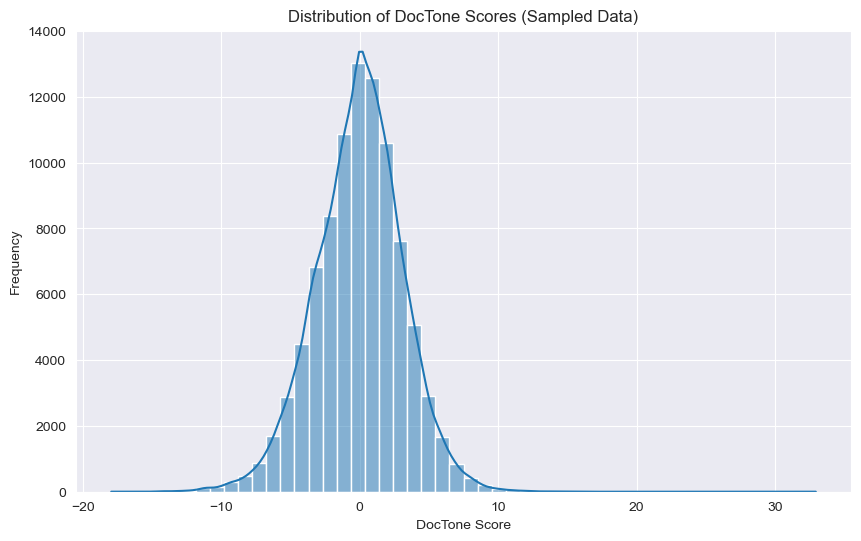

In [11]:
# Sample data for visualization (100,000 samples)
sample_df = df.select("DocTone").sample(False, 0.01, seed=42).limit(100000)

# Collect DocTone values
doc_tone_values = sample_df.rdd.map(lambda row: row['DocTone']).collect()

import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of DocTone scores
plt.figure(figsize=(10, 6))
sns.histplot(doc_tone_values, bins=50, kde=True)
plt.title('Distribution of DocTone Scores (Sampled Data)')
plt.xlabel('DocTone Score')
plt.ylabel('Frequency')
plt.show()


DocTone Statistics:

Min: -28.947368621826172

Max: 34.78260803222656

Average: -0.03639324925228623

Standard Deviation: 3.1345220942204715

0th percentile: -28.947368621826172

25th percentile: -2.0202019214630127

50th percentile: 0.0

75th percentile: 1.9910084009170532

100th percentile: 34.78260803222656

# TF-IDF + Logistic Regression

In [28]:
# Create sentiment label: Positive (2), Neutral (1), Negative (0)
def sentiment_label(score):
    if score > 1.9910:
        return 2
    elif score < -2.0202:
        return 0
    else:
        return 1
    
sentiment_udf = udf(sentiment_label, IntegerType())

df = df.withColumn("label", sentiment_udf(col("DocTone")))

label_counts = df.groupBy("label").count().orderBy("label")
label_counts.show()

+-----+-------+
|label|  count|
+-----+-------+
|    0|2297409|
|    1|4586529|
|    2|2301367|
+-----+-------+



In [29]:
# Tokenize
tokenizer = Tokenizer(inputCol="ContextualText", outputCol="words")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Feature extraction (TF-IDF)
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

In [30]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

pipelineModel = pipeline.fit(trainingData)
trainingData = pipelineModel.transform(trainingData)
testData = pipelineModel.transform(testData)

# Train logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, family='multinomial')
lrModel = lr.fit(trainingData)


24/09/27 01:17:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/27 01:18:50 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 17.0 MiB so far)
24/09/27 01:18:50 WARN BlockManager: Persisting block rdd_164_0 to disk instead.
24/09/27 01:26:14 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:21 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:31 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:40 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:26:52 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:27:03 WARN MemoryStore: Not enough space to cache rdd_164_0 in memory! (computed 419.2 MiB so far)
24/09/27 01:27:15 WARN MemoryStore: 

In [32]:
# Make predictions
predictions = lrModel.transform(testData)

In [33]:
# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % accuracy)

Test Accuracy = 0.729166 


In [35]:
# Detailed evaluation
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7310097965622986
Recall: 0.7291663150352512
F1 Score: 0.728252326514687


# Word2Vec + Random Forest

In [ ]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.classification import RandomForestClassifier

# Create sentiment label: Positive (2), Neutral (1), Negative (0)
def sentiment_label(score):
    if score > 1.9910:
        return 2
    elif score < -2.0202:
        return 0
    else:
        return 1
    
sentiment_udf = udf(sentiment_label, IntegerType())

df = df.withColumn("label", sentiment_udf(col("DocTone")))
tokenizer = Tokenizer(inputCol="ContextualText", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# Feature extraction (Word2Vec)
word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_words", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, remover, word2Vec])
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

pipelineModel = pipeline.fit(trainingData)
trainingData = pipelineModel.transform(trainingData)
testData = pipelineModel.transform(testData)

# Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=50, maxDepth=10, seed=42)

rfModel = rf.fit(trainingData)

24/09/27 02:30:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [ ]:
predictions = rfModel.transform(testData)

In [ ]:
# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % accuracy)

# Detailed evaluation
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

predictions.select("ContextualText", "label", "prediction").show(10, truncate=50)